**Imports**

In [ ]:
import time
import numpy as np
import optuna
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

**Load data**

In [74]:
def load_data():
    digits = load_digits()
    X_train, X_test, y_train, y_test = train_test_split(
        digits.data, digits.target, test_size=0.2, random_state=42
    )
    return X_train, X_test, y_train, y_test

X_train, X_test, y_train, y_test = load_data()

In [75]:
def no_optimization(X_train, y_train):
    clf = RandomForestClassifier(random_state=42)
    start_time = time.time()
    clf.fit(X_train, y_train)
    end_time = time.time()
    return clf.get_params(), end_time - start_time

In [76]:
print("Running No Optimization...")
no_opt_params, no_opt_time = no_optimization(X_train, y_train)
print(f"Default Parameters: {no_opt_params}, Time: {no_opt_time:.2f}s")

Running No Optimization...
Default Parameters: {'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': False}, Time: 0.78s


**OPTIMIZATIONS**

**Grid Search**

In [77]:
def grid_search(X_train, y_train):
    param_grid = {
        'n_estimators': [50, 100, 200],
        'max_depth': [None, 10, 20],
        'min_samples_split': [2, 5, 10]
    }

    clf = RandomForestClassifier(random_state=42)
    grid_search = GridSearchCV(clf, param_grid, cv=3, n_jobs=-1)

    start_time = time.time()
    grid_search.fit(X_train, y_train)
    end_time = time.time()

    return param_grid, grid_search.best_params_, end_time - start_time

In [78]:
print("Running Grid Search...")
param_grid, grid_params, grid_time = grid_search(X_train, y_train)
print(f"Best Parameters: {grid_params}, Time: {grid_time:.2f}s")

Running Grid Search...
Best Parameters: {'max_depth': 10, 'min_samples_split': 2, 'n_estimators': 200}, Time: 5.39s


**Random Search**

In [79]:
def random_search(X_train, y_train):
    param_dist = {
        'n_estimators': np.arange(50, 201, 50),
        'max_depth': [None, 10, 20],
        'min_samples_split': [2, 5, 10]
    }

    clf = RandomForestClassifier(random_state=42)
    rand_search = RandomizedSearchCV(
        clf, param_dist, n_iter=10, cv=3, n_jobs=-1, random_state=42)

    start_time = time.time()
    rand_search.fit(X_train, y_train)
    end_time = time.time()

    return rand_search.best_params_, end_time - start_time

In [80]:
print("Running Random Search...")
rand_params, rand_time = random_search(X_train, y_train)
print(f"Best Parameters: {rand_params}, Time: {rand_time:.2f}s")

Running Random Search...
Best Parameters: {'n_estimators': np.int64(100), 'min_samples_split': 2, 'max_depth': 10}, Time: 1.01s


**Bayesian Search**

In [81]:
def bayesian_optimization(X_train, y_train):
    def objective(trial):
        n_estimators = trial.suggest_int('n_estimators', 50, 200, step=50)
        max_depth = trial.suggest_categorical('max_depth', [None, 10, 20])
        min_samples_split = trial.suggest_int(
            'min_samples_split', 2, 10, step=3)

        clf = RandomForestClassifier(
            n_estimators=n_estimators,
            max_depth=max_depth,
            min_samples_split=min_samples_split,
            random_state=42
        )
        clf.fit(X_train, y_train)
        return accuracy_score(y_train, clf.predict(X_train))

    study = optuna.create_study(direction='maximize')
    start_time = time.time()
    study.optimize(objective, n_trials=10)
    end_time = time.time()

    return study.best_params, end_time - start_time

In [82]:
print("Running Bayesian Optimization...")
bayes_params, bayes_time = bayesian_optimization(X_train, y_train)
print(f"Best Parameters: {bayes_params}, Time: {bayes_time:.2f}s")

[I 2025-03-26 00:01:41,675] A new study created in memory with name: no-name-e90463b4-724b-4b5b-939d-671ff12a2032


Running Bayesian Optimization...


c:\Users\shefs\AppData\Local\Programs\Python\Python312\Lib\site-packages\optuna\distributions.py:699: UserWarning: The distribution is specified by [2, 10] and step=3, but the range is not divisible by `step`. It will be replaced by [2, 8].
  warnings.warn(
[I 2025-03-26 00:01:42,176] Trial 0 finished with value: 1.0 and parameters: {'n_estimators': 200, 'max_depth': None, 'min_samples_split': 8}. Best is trial 0 with value: 1.0.
c:\Users\shefs\AppData\Local\Programs\Python\Python312\Lib\site-packages\optuna\distributions.py:699: UserWarning: The distribution is specified by [2, 10] and step=3, but the range is not divisible by `step`. It will be replaced by [2, 8].
  warnings.warn(
[I 2025-03-26 00:01:42,686] Trial 1 finished with value: 1.0 and parameters: {'n_estimators': 200, 'max_depth': 10, 'min_samples_split': 8}. Best is trial 0 with value: 1.0.
c:\Users\shefs\AppData\Local\Programs\Python\Python312\Lib\site-packages\optuna\distributions.py:699: UserWarning: The distribution is

Best Parameters: {'n_estimators': 200, 'max_depth': None, 'min_samples_split': 8}, Time: 4.35s


**Plot**

In [83]:
def plot_detailed_comparison(grid_time, rand_time, bayes_time, grid_params, rand_params, bayes_params, X_train, X_test, y_train, y_test, param_grid):
    methods = ['Grid Search', 'Random Search', 'Bayesian Optimization']
    times = [grid_time, rand_time, bayes_time]

    # Training and Test Accuracies
    grid_clf = RandomForestClassifier(**grid_params, random_state=42)
    grid_clf.fit(X_train, y_train)
    grid_train_acc = accuracy_score(y_train, grid_clf.predict(X_train))
    grid_test_acc = accuracy_score(y_test, grid_clf.predict(X_test))

    rand_clf = RandomForestClassifier(**rand_params, random_state=42)
    rand_clf.fit(X_train, y_train)
    rand_train_acc = accuracy_score(y_train, rand_clf.predict(X_train))
    rand_test_acc = accuracy_score(y_test, rand_clf.predict(X_test))

    bayes_clf = RandomForestClassifier(**bayes_params, random_state=42)
    bayes_clf.fit(X_train, y_train)
    bayes_train_acc = accuracy_score(y_train, bayes_clf.predict(X_train))
    bayes_test_acc = accuracy_score(y_test, bayes_clf.predict(X_test))

    train_accuracies = [grid_train_acc, rand_train_acc, bayes_train_acc]
    test_accuracies = [grid_test_acc, rand_test_acc, bayes_test_acc]

    # Overfitting Potential
    overfitting = [train - test for train, test in zip(train_accuracies, test_accuracies)]

    # Plotting
    plt.figure(figsize=(15, 8))

    # Time Comparison
    plt.subplot(2, 2, 1)
    plt.bar(methods, times, color=['blue', 'orange', 'green'])
    plt.ylabel("Time (seconds)")
    plt.title("Execution Time")

    # Training vs. Test Accuracy
    plt.subplot(2, 2, 2)
    plt.bar(methods, train_accuracies, color='skyblue', alpha=0.7, label='Train Accuracy')
    plt.bar(methods, test_accuracies, color='salmon', alpha=0.7, label='Test Accuracy')
    plt.ylabel("Accuracy")
    plt.title("Training vs. Test Accuracy")
    plt.legend()

    # Overfitting Potential
    plt.subplot(2, 2, 3)
    plt.bar(methods, overfitting, color=['purple', 'red', 'green'])
    plt.ylabel("Train-Test Accuracy Gap")
    plt.title("Overfitting Potential (Train-Test Gap)")

    # Number of Evaluations
    grid_evaluations = np.prod([len(values) for values in param_grid.values()])
    random_evaluations =  10  # As specified in Randomized search
    bayesian_evaluations = 10  # As specified in Bayesian optimization
    evaluations = [grid_evaluations, random_evaluations, bayesian_evaluations]

    plt.subplot(2, 2, 4)
    plt.bar(methods, evaluations, color=['gray', 'cyan', 'pink'])
    plt.ylabel("Model Evaluations")
    plt.title("Number of Model Evaluations") #  how many different models each search method evaluated to find the best hyperparameters

    plt.tight_layout()
    plt.show()

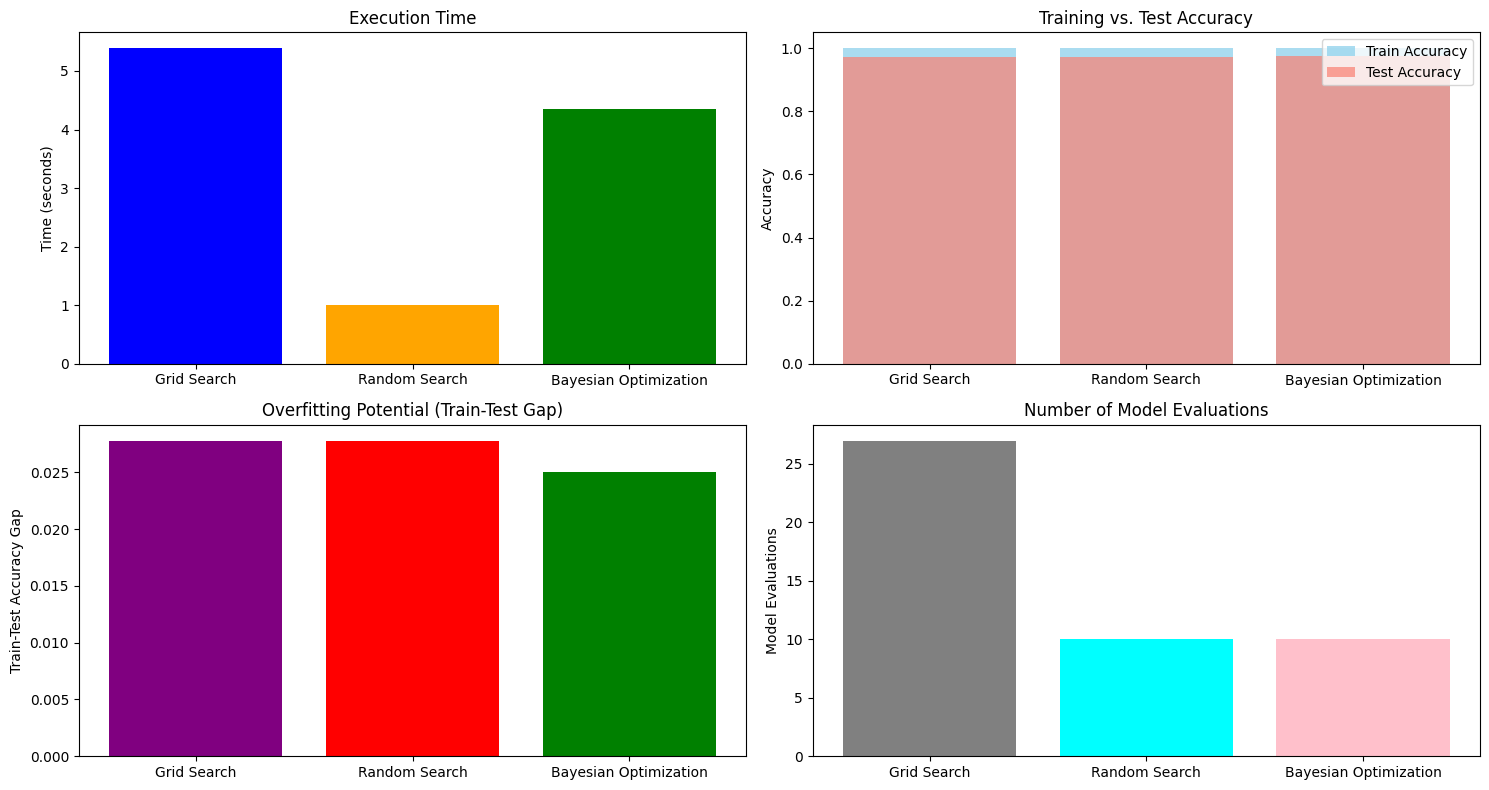

In [84]:
plot_detailed_comparison(grid_time, rand_time, bayes_time, grid_params, rand_params, bayes_params, X_train, X_test, y_train, y_test, param_grid)
